In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import json
import numpy as np
import cv2

CASE = 'TrainWith21_2'

# Utilities

In [3]:
import json
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import random
import matplotlib.pyplot as plt

def set_seed(seed):
    ''' set random seeds '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)

def filename2id(x):
    # print(f"[filename2id] x: {x}")
    return int(x.split('_')[1].split('.')[0])

def dir_filename2id(x) -> tuple:
    return (int(x.split('/')[0]), int(x.split('_')[1].split('.')[0]))

def load_labels(labels_path):
    with open(labels_path, 'r') as f:
        labels = json.load(f)
    return labels

def pad_collate_fn_unsqueeze(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True)
    labels = torch.tensor(labels)
    return features_padded.unsqueeze(1), labels

def pad_collate_fn(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True)
    labels = torch.tensor(labels)
    return features_padded, labels

def plot_learning_curve(num_epochs, curve, plot_save_path):
    legend = []
    for key, value in curve.items():
        plt.plot(range(1, num_epochs+1), value)
        legend.append(key)
        
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Loss vs. Epoch')
    plt.legend(legend)
    plt.savefig(plot_save_path)
    plt.close()
    


set_seed(7799)

# Dataset

In [4]:

            
class DoorStateDatasetTrain(Dataset):
    def __init__(self, features_dir, labels, label_idx, num_of_frames=1, spacing=5):
        super().__init__()
        if num_of_frames % 2 == 0 or num_of_frames < 1:
            raise ValueError(f"Invalid num_of_frames: {num_of_frames}")
        
        self.data = []
        self.features_dir = features_dir
        self.num_of_frames = num_of_frames
        self.spacing = spacing
        self.farthest_frame = int((num_of_frames - 1) * spacing / 2)
        self.labels = labels
        self.label_idx = label_idx
        self.total_frames = len(self.labels)
        
        for idx in tqdm(range(self.total_frames)):
            # print(self.labels[idx])
            frame_path = self.labels[idx]['frames']
            label = self.labels[idx]['label']
            feature_path = os.path.join(self.features_dir, frame_path[:-4] + ".npy")
            features = np.load(feature_path)
            features = torch.tensor(features, dtype=torch.float32)
            optical_flow = np.load(feature_path[:-4] + "_flow.npy")
            optical_flow = cv2.resize(optical_flow, (64, 64))
            optical_flow = torch.tensor(optical_flow, dtype=torch.float32)
            self.data.append((features, optical_flow,label))
        if self.num_of_frames > 1:
            self.data = self.farthest_frame * [self.data[0]] + self.data + self.farthest_frame * [self.data[-1]]

    def __len__(self):
        return len(self.label_idx)

    def __getitem__(self, idx):
        center_idx = self.label_idx[idx]
        if self.num_of_frames == 1:
            return self.data[self.label_idx[idx]]
        else:
            label = self.data[center_idx][2]
            # flow_ret = self.data[center_idx][1]
            start_frame = center_idx - self.farthest_frame
            end_frame = center_idx + self.farthest_frame
            ff = []
            fo = []
            for i in range(start_frame, end_frame+1, self.spacing):
                # print(i)
                ff.append(self.data[i][0])
                fo.append(self.data[i][1])
            fet_ret = torch.stack(ff)
            flow_ret = torch.stack(fo)
            
            return fet_ret, flow_ret, label
        
class DoorStateDatasetTest(Dataset):
    def __init__(self, features_dir, num_of_frames=1, spacing=5):
        if num_of_frames % 2 == 0 or num_of_frames < 1:
            raise ValueError(f"Invalid num_of_frames: {num_of_frames}")
        
        self.features_dir = features_dir
        self.feature_files = sorted(os.listdir(self.features_dir), key=lambda x: filename2id(x))
        self.num_of_frames = num_of_frames
        self.spacing = spacing
        self.farthest_frame = int((num_of_frames - 1) * spacing / 2)
        self.data = []
        
        for feature_file in self.feature_files:
            if 'flow' in feature_file:
                continue
            
            feature_path = os.path.join(self.features_dir, feature_file)

            # feature_path = np.array(feature_path)
            features = np.load(feature_path)
            features = torch.tensor(features, dtype=torch.float32)
            
            optical_flow = np.load(feature_path[:-4] + "_flow.npy") # (224, 224, 2)
            optical_flow = cv2.resize(optical_flow, (64, 64))
            optical_flow = torch.tensor(optical_flow, dtype=torch.float32)
            
            self.data.append((features, optical_flow))
        
        self.total_frames = len(self.data)
        
        if self.num_of_frames > 1:
            self.data = self.farthest_frame * [self.data[0]] + self.data + self.farthest_frame * [self.data[-1]]
        

    def __len__(self):
        # Return the number of feature files
        return self.total_frames

    def __getitem__(self, idx):
        if self.num_of_frames == 1:
            return self.data[idx]
        else:
            start_frame = idx - self.farthest_frame
            end_frame = idx + self.farthest_frame
            ff = []
            fo = []
            for i in range(start_frame, end_frame+1, self.spacing):
                ff.append(self.data[i][0])
                fo.append(self.data[i][1])
            fet_ret = torch.stack(ff)
            flow_ret = torch.stack(fo)
            
            return fet_ret, flow_ret

# Model

In [5]:
import torch.nn.init as init

class CNNRNNModel(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, num_classes, rnn_layers=3, dropout=0.5):
        super(CNNRNNModel, self).__init__()

        # RNN layers with increased complexity
        self.conv_size = 16384
        self.rnn = nn.LSTM(input_size=input_size+self.conv_size, hidden_size=rnn_hidden_size, num_layers=rnn_layers, batch_first=True, dropout=dropout)

        # CNN layers for optical flow
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Fully connected layers with increased complexity
        self.fc1 = nn.Linear(rnn_hidden_size, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.xavier_uniform_(self.fc3.weight)

    def forward(self, fet, flow):
        # print(flow.shape)
        batch_size, timestep, H, W, C = flow.size()
        flow = flow.reshape(batch_size*timestep, H, W, C)
        flow = flow.permute(0, 3, 1, 2)

        # Apply CNN layers for optical flow
        flow = self.pool(self.relu(self.bn1(self.conv1(flow))))
        flow = self.pool(self.relu(self.bn2(self.conv2(flow))))
        flow = self.pool(self.relu(self.bn3(self.conv3(flow))))

        flow_flatten = flow.reshape(batch_size, timestep, -1)

        # Apply RNN layers
        # print(flow_flatten.shape)
        # print(fet.shape)
        rnn_in = torch.cat((fet, flow_flatten), dim=2)
        # print(rnn_in.shape)
        rnn_out, _ = self.rnn(rnn_in)
        rnn_out_last = rnn_out[:, -1, :]
        # Apply fully connected layers
        x = self.fc1(rnn_out_last)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.fc3(x)
        return out

# Training

In [ ]:


# data
frames_per_input = 21
spacing = 2

# model
os.makedirs(f"/kaggle/working/{CASE}", exist_ok=True)
model_dir = f"/kaggle/working/{CASE}/models"
input_size = 2048  # Example input size
rnn_hidden_size = 512
rnn_layers = 5
num_classes = 4

# training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
learning_rate = 0.00005
num_epochs = 500
batch_size = 16
early_stop = 15
plot_dir = f"/kaggle/working/{CASE}/plots"
os.makedirs(plot_dir, exist_ok=True)

# # Load labels
labels_path = '/kaggle/input/cvfp-101/data/labels/labels.json'
labels = load_labels(labels_path)

# Split into training and validation sets
train_idx, val_idx = train_test_split(range(len(labels)), test_size=0.2, random_state=696)

# Create datasets and data loaders
train_dataset = DoorStateDatasetTrain('/kaggle/input/cvfp-101/data/features_101', labels, train_idx, num_of_frames=frames_per_input, spacing=spacing)
val_dataset = DoorStateDatasetTrain('/kaggle/input/cvfp-101/data/features_101', labels, val_idx, num_of_frames=frames_per_input, spacing=spacing)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = CNNRNNModel(input_size=input_size, rnn_hidden_size=rnn_hidden_size, num_classes=num_classes, rnn_layers=rnn_layers, dropout=0.5)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create directory for saving models if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# # Adjust learning rate if necessary
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Training loop
best_val_loss = float('inf')
best_train_loss = float('inf')
early_stop_ct = early_stop
curve = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for features, flow, labels in train_loader:
            features = features.to(device)
            flow = flow.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features, flow)

            # outputs = outputs.view(-1, outputs.size(-1))  # Reshape for the loss function
            # labels = labels.view(-1)  # Reshape for the loss function

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
            pbar.update(1)
            pbar.set_postfix(loss=running_loss / ((pbar.n + 1) * train_loader.batch_size))

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    curve['train_loss'].append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for fet, flow, labels in val_loader:
            fet = fet.to(device)
            flow = flow.to(device)
            labels = labels.to(device)
            
            outputs = model(fet, flow)

            # outputs = outputs.view(-1, outputs.size(-1))  # Reshape for the loss function
            # labels = labels.view(-1)  # Reshape for the loss function

            loss = criterion(outputs, labels)
            val_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
    curve['val_loss'].append(val_loss)

    # # Adjust learning rate
    # scheduler.step(val_loss)

    # Save the model checkpoint
    plot_learning_curve(epoch+1, curve, plot_save_path=os.path.join(plot_dir, 'learning_curve.png'))
    flag = 0
    if (best_val_loss > val_loss):
        print('lower val')
        best_val_loss = val_loss
        flag = 1
        early_stop_ct = min(early_stop_ct+1, early_stop)
    elif (best_train_loss > epoch_loss):
        print('lower train')
        best_train_loss = epoch_loss
        early_stop_ct = min(early_stop_ct+2, early_stop)
        flag = 1
    else:
        early_stop_ct -= 1
        if (early_stop_ct < 0):
            print(f"early stop af epoch {epoch}")
            break 
    if (flag):
        best_train_loss = min(best_train_loss, epoch_loss)
        best_val_loss = min(best_val_loss, val_loss)
        model_save_path = os.path.join(model_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}')

Using device: cuda


 12%|█▏        | 500/4152 [00:11<01:24, 43.22it/s]

# Testing

/kaggle/input/cvfp-101/data/frames_test


Processing videos:   0%|          | 0/5 [00:00<?, ?it/s]

Predicted logits for 07:
(252, 4)


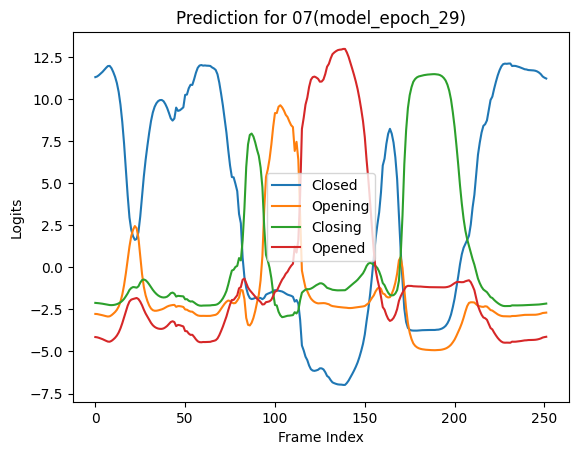

Processing videos:  20%|██        | 1/5 [00:02<00:08,  2.11s/it]

Predicted logits for 05:
(456, 4)


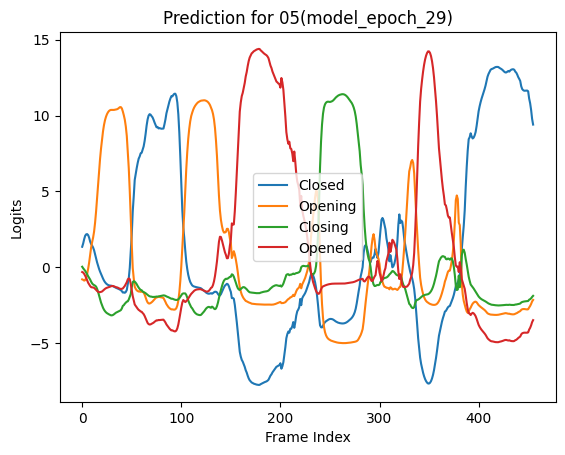

Processing videos:  40%|████      | 2/5 [00:05<00:08,  2.85s/it]

Predicted logits for 09:
(570, 4)


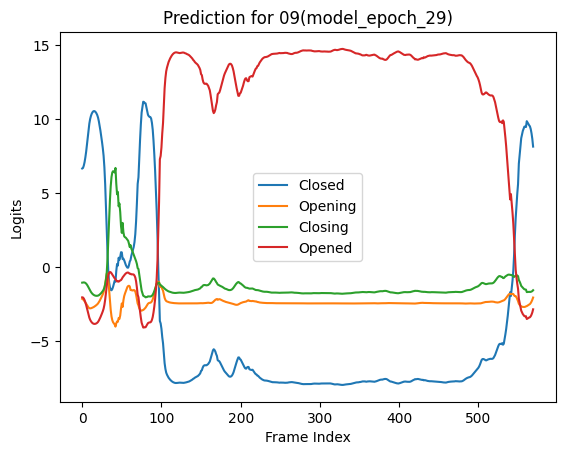

Processing videos:  60%|██████    | 3/5 [00:09<00:06,  3.37s/it]

Predicted logits for 03:
(334, 4)


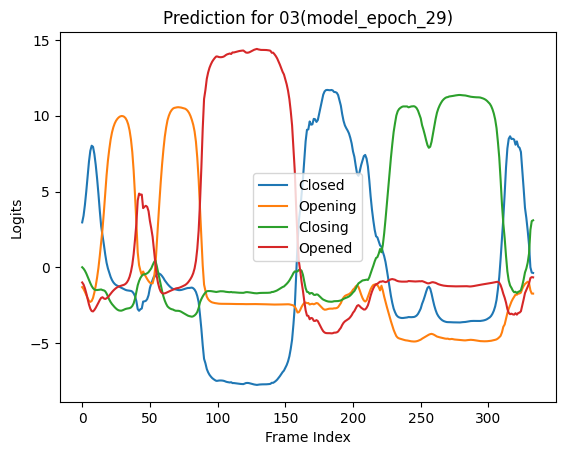

Processing videos:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

In [ ]:
import os
import json
import torch
import numpy as np
from torchvision import models, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
# from model import CNNRNNModel
from PIL import Image
from tqdm import tqdm
# from train import DoorStateDataset
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# from utils import filename2id
# from dataset import DoorStateDatasetTest

# config
# data
frames_per_input = 41
spacing = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




def load_model(model_path, input_size, rnn_hidden_size, num_classes, rnn_layers):
    model = CNNRNNModel(input_size=input_size, rnn_hidden_size=rnn_hidden_size, num_classes=num_classes, rnn_layers=rnn_layers, dropout=0.5)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    model.to(device)
    model.eval()
    return model


def guess_door_states(model, test_loader):
    """ Use the model to predict the frames for door states. """
    # print(frame_dir)
    # frames = [f for f in os.listdir(frame_dir)]
    # print(frames)

    all_outputs = []

    with torch.no_grad():
        for fet_batch, flow_batch in test_loader:
            fet_batch = fet_batch.to(next(model.parameters()).device)  # Ensure the batch is on the same device as the model
            # print(batch.shape)
            flow_batch = flow_batch.to(next(model.parameters()).device)
            outputs = model(fet_batch, flow_batch)
            all_outputs.append(outputs.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0)
    return all_outputs



def scan_videos(frame_dir, feature_dir, model, model_name='CNNRNN'):
    """Scan the specified directory for feature_test folders and generate JSON annotations."""
    frame_dir_full = frame_dir
    frame_dir = [f for f in os.listdir(frame_dir) if os.path.isdir(os.path.join(frame_dir, f))]

    print(frame_dir_full)

    videos_info = []
    batch_size = 16

    for frame in tqdm(frame_dir, desc="Processing videos"):
        # feature_dir = os.path.join(feature_dir, video_dir)
        video_dir = os.path.join(frame, '.mp4')
        feature_dir_in_frame = os.path.join(feature_dir, frame)
        frame_subdir  = os.path.join(frame_dir_full, frame)
        test_dataset = DoorStateDatasetTest(feature_dir_in_frame, num_of_frames=frames_per_input, spacing=spacing)
        test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle= False)

        # opening_frame, closing_frame = guess_door_states(model, frame_dir_full , test_loader)

        outputs = guess_door_states(model, test_loader)
        predicted_logits = outputs.squeeze()
        
        plot_predictions(frame, predicted_logits, model=model_name)

        frames = [f for f in os.listdir(frame_subdir)]
        # print(frames)

        opening_logits = predicted_logits[:, 1]  # Logits for "opening" class
        closing_logits = predicted_logits[:, 2]  # Logits for "closing" class
        opening_frame = frames[np.argmax(opening_logits)] if np.max(opening_logits) > 0.5 else -1
        closing_frame = frames[np.argmax(closing_logits)] if np.max(closing_logits) > 0.5 else -1

        videos_info.append({
            "video_filename": video_dir,
            "annotations": [
                {
                    "object": "Door",
                    "states": [
                        {
                            "state_id": 1,
                            "description": "Opening",
                            "guessed_frame": opening_frame  # Predicted opening frame
                        },
                        {
                            "state_id": 2,
                            "description": "Closing",
                            "guessed_frame": closing_frame  # Predicted closing frame
                        }
                    ]
                }
            ]
        })

    return videos_info

def generate_json(output_filename, videos_info):
    """Generate a JSON file with the provided video information."""
    with open(output_filename, 'w') as file:
        json.dump({"videos": videos_info}, file, indent=4)

def plot_predictions(frame, predicted_logits, model):
    os.makedirs("plots", exist_ok=True)
    # Plot the prediction logits
    print(f"Predicted logits for {frame}:")
    print(predicted_logits.shape)
    plt.plot(predicted_logits)
    plt.xlabel('Frame Index')
    plt.ylabel('Logits')
    plt.legend(['Closed', 'Opening', 'Closing', 'Opened'])
    plt.title(f"Prediction for {frame}({model})")
#     plt.savefig(f"plots/prediction_{frame}_{model}.png")
    plt.show()
    plt.clf()

def main():
    os.makedirs(f"/kaggle/working/{CASE}", exist_ok=True)
    frame_dir = "/kaggle/input/cvfp-101/data/frames_test"  # Specify the directory containing test video frames
    feature_dir = "/kaggle/input/cvfp-101/data/features_test_101" # Specify the directory containing test features by processing test video frames
    output_filename = f"/kaggle/working/{CASE}/output.json"  # Output JSON file name
    model_path = "/kaggle/working/models/model_epoch_29.pth"  # Path to the trained model file
    input_size = 2048  # Example input size, should match your precomputed feature size
    rnn_hidden_size = 512
    num_classes = 4
    rnn_layers = 5  # Ensure this matches the training configuration

    # Load the trained model
    model = load_model(model_path, input_size, rnn_hidden_size, num_classes, rnn_layers)

    # Process the videos and generate JSON annotations
    videos_info = scan_videos(frame_dir, feature_dir, model, model_path.split('/')[-1].split('.')[0])
    generate_json(output_filename, videos_info)
    print(f"Generated JSON file '{output_filename}' with video annotations.")


main()


